<a 
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab10.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

# Lab 10: Transfer Learning/Fine-Tuning

## Description

### Objective

- Gain experience fine-tuning pre-trained models to domain-specific applications.

### Deliverable

For this lab you will submit an ipython notebook via learning suite. The bulk of the work is in modifying fine-tuning a pre-trained ResNet. Fine-tuning the GPT-2 language model is pretty easy. The provided code works as is; you will just have to swap in your own text dataset.

### Grading

- 35% Create a dataset class for your own dataset
- 35% Create a network class that wraps a pretrained ResNet
- 20% Implement unfreezing in the network class
- 10% Fine-tune GPT-2 on your own dataset

### Tips
- Your life will be better if you download a dataset that already has the data in the expected format for ImageFolder (make sure to read the documentation!). The datasets recommended below are in the correct format.
- Get the CNN working on the provided dataset (bird species classification) before swapping in your own.
- For reference on freezing/unfreezing network weights, see [this github gist](https://gist.github.com/jcjohnson/6e41e8512c17eae5da50aebef3378a4c)
- For training GPT-2, first try the medium-size (355M parameter) model. If your Colab instance doesn't have enough GPU space, you may need to switch to the small-size (124M parameter) model, but the results will be less impressive.

In [1]:
from torchvision.models import resnet152
from torchvision.models import resnet18
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch
from torch import optim, nn
import zipfile
from google.colab import files
import os
import sys
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import pdb

## 1 Fine-tune a ResNet for image classification

### 1.1 Find a dataset to fine-tune on, and make a Dataset class (1 hr.)

#### TODO:

#### DONE:
- Inherit from torch.utils.data.Dataset
- Use a [torchvision.datasets.ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder)
- Don't spend too long finding another dataset. Some suggestions that you are free to use:
 - https://www.kaggle.com/jessicali9530/stanford-dogs-dataset
 - https://www.kaggle.com/puneet6060/intel-image-classification


#### Help for downloading kaggle datasets
Downloading Kaggle datasets requires authentication, so you can't just download from a url. Here are some step-by-step instructions of how to get Kaggle datasets in Colab

1. Create an API key in Kaggle
    - Click on profile photo
    - Go to 'My Account'
    - Scroll down to the API access section and click "Create New API Token"
    - `kaggle.json` is now downloaded to your computer

2. Upload the API key and install the Kaggle API client by running the next cell (run it again if it throws an error the first time). Also, `files.upload()` may not work in Firefox. One solution is to expand the Files banner (indicated by the '>' tab on the left side of the page) and use that to upload the key.

In [2]:
# # Run this cell and select the kaggle.json file downloaded
# # from the Kaggle account settings page.
# from google.colab import files
# files.upload()
# # Next, install the Kaggle API client.
# !pip install -q kaggle
# # Let's make sure the kaggle.json file is present.
# !ls -lha kaggle.json
# # The Kaggle API client expects this file to be in ~/.kaggle,
# # so move it there.
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# # This permissions change avoids a warning on Kaggle tool startup.
# !chmod 600 ~/.kaggle/kaggle.json

3. Copy the desired dataset locally

In [3]:
# Example download command for dataset found here: https://www.kaggle.com/akash2907/bird-species-classification
# !kaggle datasets download -d akash2907/bird-species-classification

#### Make the Dataset class
See the implementation below for reference, and implement a dataset class for the dataset you choose.

In [4]:
# class BirdDataset(Dataset):
#     def __init__(self, zip_file='bird-species-classification.zip', size=256, train=True, upload=False):
#         super(BirdDataset, self).__init__()
        
#         self.train = train
#         extract_dir = os.path.splitext(zip_file)[0]
#         if not os.path.exists(extract_dir):
#             os.makedirs(extract_dir)
#             self.extract_zip(zip_file, extract_dir)
#             # Resize the images - originally they are high resolution. We could do this
#             # in the DataLoader, but it will read the full-resolution files from disk
#             # every time before resizing them, making training slow
#             self.resize(extract_dir, size=size)

#         postfix = 'train' if train else 'test'
            
#         if train:
#             # The bird-species dataset mistakenly has a train_data folder inside of train_data
#             self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'train_data', 'train_data'), transform=transforms.Compose([transforms.ToTensor()]))
#         else:
#             self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'test_data', 'test_data'), transform=transforms.Compose([transforms.ToTensor()]))

#     def extract_zip(self, zip_file, extract_dir):
#         print("Extracting", zip_file)
#         with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#             zip_ref.extractall(extract_dir)

#     def resize(self, path, size=256):
#         """Resizes all images in place"""
#         print("Resizing images")
#         dirs = os.walk(path)
#         for root, dirs, files in os.walk(path):
#             for item in files:
#                 name = os.path.join(root, item)
#                 if os.path.isfile(name):
#                     im = Image.open(name)
#                     im = ImageOps.fit(im, (size, size))
#                     im.save(name[:-3] + 'bmp', 'BMP')
#                     os.remove(name)

#     def __getitem__(self, i):
#         return self.dataset_folder[i]

#     def __len__(self):
#         return len(self.dataset_folder)

# bird_data = BirdDataset()

In [5]:
#########################
# Implement your own Dataset
# !unzip -n archive.zip -d ./content/
#########################

### 1.2 Wrap a pretrained ResNet in an `nn.Module` (30 min)

#### TODO:

#### DONE:
- Make a model class that inherits from `nn.Module`
- Wrap a pretrained ResNet and swap out the last layer of that network with a layer that maps to the number of classes in your new dataset

#### Make your model class

In [6]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes, start_frozen=False):
        super(CustomResNet, self).__init__()

        # Part 1.2
        # Load the model - make sure it is pre-trained
        self.model = resnet18(pretrained=True)

        # Part 1.4
        if start_frozen:
          for param in self.model.parameters():
            param.requires_grad = False
        
        # Part 1.2
        # Look at the code of torchvision.models.resnet152 (or print the ResNet object) to find the name of the attribute to override (the last layer of the ResNet)
        # Override the output linear layer of the neural network to map to the correct number of classes. Note that this new layer has requires_grad = True
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
        
    def unfreeze(self, n_layers):
        # Part 1.4
        # Turn on gradients for the last n_layers
        for i, param in enumerate(self.model.parameters()):
          if i >= num_parameters(self.model) - n_layers:
            param.requires_grad = True
          # else:
          #   param.requires_grad = False

    def forward(self, x):
        # Part 1.2
        # Pass x through the resnet
        return self.model(x)

def num_parameters(model):
    return sum(1 for p in model.parameters())

### 1.3 Read through and run this training loop

In [7]:
def accuracy(y_hat, y_truth):
    """Gets average accuracy of a vector of predictions"""
    
    preds = torch.argmax(y_hat, dim=1)
    acc = torch.mean((preds == y_truth).float())
    return acc

def evaluate(model, objective, val_loader, device):
    """Gets average accuracy and loss for the validation set"""

    val_losses = []
    val_accs = []
    # model.eval() so that batchnorm and dropout work in eval mode
    model.eval()
    # torch.no_grad() to turn off computation graph creation. This allows for temporal
    # and spatial complexity improvements, which allows for larger validation batch 
    # sizes so it’s recommended
    with torch.no_grad():
        for x, y_truth in val_loader:

            x, y_truth = x.to(device), y_truth.to(device)
            y_hat = model(x)
            val_loss = objective(y_hat, y_truth)
            val_acc = accuracy(y_hat, y_truth)

            val_losses.append(val_loss.item())
            val_accs.append(val_acc)

    model.train()

    return torch.mean(torch.Tensor(val_losses)), torch.mean(torch.Tensor(val_accs))

In [8]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def train(start_frozen=False, model_unfreeze=0):
    """Fine-tunes a CNN
    Args:
        start_frozen (bool): whether to start with the network weights frozen.
        model_unfreeze (int): the maximum number of network layers to unfreeze
    """
    epochs = 20
    # Start with a very low learning rate
    lr = .00005
    val_every = 3
    batch_size = 32
    img_size = 224
    device = torch.device('cuda:0')

    # Data
    my_dataset = datasets.ImageFolder(root='./content/images/Images',
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
                           ]))
    num_classes = len(my_dataset.classes)
    
    will_use = 2000
    wont_use = len(my_dataset)-will_use
    will, wont = torch.utils.data.random_split(my_dataset, [will_use, wont_use])
    train_length = int(0.8 * len(will))
    test_length = len(will) - train_length
    train_data, test_data = torch.utils.data.random_split(will, [train_length, test_length])
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

    # train_dataset = BirdDataset(upload=True, train=True)
    # val_dataset = BirdDataset(upload=True, train=False)
    # train_loader = DataLoader(train_dataset,
    #                           shuffle=True,
    #                           num_workers=8,
    #                           batch_size=batch_size)
    # val_loader = DataLoader(val_dataset,
    #                           shuffle=True,
    #                           num_workers=8,
    #                           batch_size=batch_size)
    
    # Model
    model = CustomResNet(num_classes, start_frozen=start_frozen).to(device)
    
    # Objective
    objective = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-1)

    # Progress bar
    pbar = tqdm(total=len(train_loader) * epochs)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    cnt = 0
    for epoch in range(epochs):

        # Implement model unfreezing
        if epoch < model_unfreeze:
            # Part 1.4
            model.unfreeze(epoch)
        
        for x, y_truth in train_loader:
        
            x, y_truth = x.to(device), y_truth.to(device)

            optimizer.zero_grad()

            y_hat = model(x)
            train_loss = objective(y_hat, y_truth)
            train_acc = accuracy(y_hat, y_truth)

            train_loss.backward()
            optimizer.step()

            train_accs.append(train_acc)
            train_losses.append(train_loss.item())

            if cnt % val_every == 0:
                val_loss, val_acc = evaluate(model, objective, val_loader, device)
                val_losses.append(val_loss)
                val_accs.append(val_acc)

            pbar.set_description('train loss:{:.4f}, train accuracy:{:.4f}.'.format(train_loss.item(), train_acc))
            pbar.update(1)
            cnt += 1

    pbar.close()
    plt.subplot(121)
    plt.plot(np.arange(len(train_accs)), train_accs, label='Train Accuracy')
    plt.plot(np.arange(len(train_accs), step=val_every), val_accs, label='Val Accuracy')
    plt.legend()
    plt.subplot(122)
    plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(np.arange(len(train_losses), step=val_every), val_losses, label='Val Loss')
    plt.legend()
    plt.show()  

In [9]:
# model = CustomResNet(120, start_frozen=False)
# print(num_parameters(model))
# count = 0
# for param in model.parameters():
#   count += 1
# print(count)
# my_dataset = datasets.ImageFolder(root='./content/images/Images',
#                            transform=transforms.Compose([
#                                transforms.Resize(224),
#                                transforms.CenterCrop(224),
#                                transforms.ToTensor(),
#                                transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
#                            ]))
# print(len(my_dataset))

In [10]:
# train(start_frozen=False, model_unfreeze=0)  

### 1.4 Implement Unfreezing (1 hr)

#### Description

Unfreezing is a technique that can be helpful when fine tuning a CNN for a more difficult task with a large amount of data.

The idea is that if we allow the network to tweak the earliest layers immediately, before the last FCL has been trained at all, the earliest layers will forget all of the useful features that they learned in order  to provide features that are helpful for the (untrained) FCL.

So, rather than training all of the model weights at once, we learn the last fully connected layer, then train that layer together with the second-to-last layer, gradually adding layers until we reach the first layer.

#### TODO:

#### DONE:
- Modify your model class by setting the `requires_grad` attribute of the ResNet to `False`. (but keep `requires_grad = True` for the last layer).
- Add a member function to you model class that allows the user to unfreeze weights in the training loop. See [this github gist](https://gist.github.com/jcjohnson/6e41e8512c17eae5da50aebef3378a4c) for reference.
- Modify your training loop to add logic that calls the `unfreeze` function of the model class (unfreeze one layer every epoch).
- Call your train function to fine-tune the ResNet on your dataset.

#### Call your train function

train loss:0.8114, train accuracy:1.0000.: 100%|██████████| 1000/1000 [15:25<00:00,  1.08it/s]


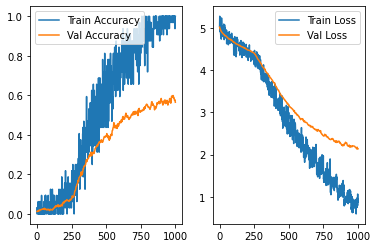

In [11]:
############################
# train with unfreezing here (should be a single call to your train function)
train(start_frozen=True, model_unfreeze=20)
############################

You may not see any improvement for your classification task, but unfreezing can help convergence for more difficult image classification tasks.

## 2 Fine-tune a language model - (15 min)

In this section you will use the gpt-2-simple package [here](https://github.com/minimaxir/gpt-2-simple) to fine-tune the GPT-2 language model on a domain of your choice.

### 2.1 Generate text from an the pretrained GPT-2 model

#### Run this code to generate text from a pretrained model

In [12]:
!pip install gpt-2-simple

# the transformers package is built on top of Tensorflow, and the default TF version 
# for Colab will soon switch to 2.x. We remedy this with the following magic method
%tensorflow_version 1.x 

import gpt_2_simple as gpt2
import os
import tensorflow as tf

TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [13]:
# This line is necessary to be able to run a new tf session
tf.reset_default_graph()
# The medium-sized model. IF you run out of memory, try "124M" instead
model_name = "124M"
if not os.path.isdir(os.path.join("models", model_name)):
	print(f"Downloading {model_name} model...")
	gpt2.download_gpt2(model_name=model_name)   # model is saved into current directory under /models/124M/

sess = gpt2.start_tf_sess()
gpt2.load_gpt2(sess, model_name=model_name)
gpt2.generate(sess, model_name=model_name)

Loading pretrained model models/124M/model.ckpt
INFO:tensorflow:Restoring parameters from models/124M/model.ckpt
The harmful effects of open health care access are very real; it's not clear how they're being mitigated. We're concerned about the impact of the Affordable Care Act, particularly the practice of allowing corporations to refuse to serve Medicare or Medicaid patients and to withhold public funds from certain programs that benefit people with chronic conditions, such as HIV/AIDS, diabetes and cancer.

We must have a principled, bipartisan approach to this problem. We know that the public health care system needs to be run by the American people, not just by corporations. We know that the Affordable Care Act is a tax on Americans and the private sector can do its part. We know that the public health care system needs to be accountable to working Americans, not just the wealthy. And we know that the ACA needs to be addressed by Democrats, not just Republicans.

The opinions expr

### 2.2 Download a text dataset

#### TODO:

#### DONE:
- Use the provided functions to download your own text dataset
- [Project Gutenberg](https://www.gutenberg.org/) is a nice starting point for raw text corpora

#### Download Dataset

In [14]:
# import zipfile
# import os
# from torchvision import datasets

# def extract_zip(zip_path, remove_finished=True):
#     print('Extracting {}'.format(zip_path))
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall(zip_path.replace('.zip', ''))
#     if remove_finished:
#         os.remove(zip_path)

# def download_dataset(url, root='../data'):
#     if not os.path.exists(os.path.join(root, 'text')):
#         os.makedirs(os.path.join(root))
#         datasets.utils.download_url(url, root, 'text.zip', None)
#         extract_zip(os.path.join(root, 'text.zip'))
#     return os.path.join(root, 'text')

# ##########################################
# # Set the url for your dataset here,
# # move the dataset to the desired location
# ##########################################
# # https://www.gutenberg.org/cache/epub/17192/pg17192.txt
# url = 'https://www.gutenberg.org/files/30/30.zip'
# download_dataset(url)
# !mv /data/text/30.txt /data/text/bible.txt
# !ls ../data/text

### 2.3 Fine-tune GPT-2 on your own dataset

#### TODO:

#### DONE:
- Swap out the dataset parameter with the path to your dataset

#### Train on your dataset

In [15]:
# This line is necessary to be able to run a new tf session if one has already been run
tf.reset_default_graph()
# Start a session
sess = gpt2.start_tf_sess()
# Fine tune `model_name` on `data`
###################################
# Swap out the `dataset` parameter with the path to your text dataset
###################################
gpt2.finetune(sess,
              dataset='./raven.txt',
              model_name=model_name,
              restore_from='latest',
              steps=500)   # steps is max number of training steps

gpt2.generate(sess, run_name='run1')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Loading checkpoint checkpoint/run1/model-172
INFO:tensorflow:Restoring parameters from checkpoint/run1/model-172


100%|██████████| 1/1 [00:00<00:00, 356.69it/s]

Loading dataset...
dataset has 13639 tokens
Training...


[1 | 8.86] loss=0.06 avg=0.06
[2 | 11.30] loss=0.07 avg=0.06
[3 | 13.78] loss=0.08 avg=0.07
[4 | 16.27] loss=0.06 avg=0.06
[5 | 18.79] loss=0.07 avg=0.07
[6 | 21.35] loss=0.07 avg=0.07
[7 | 23.91] loss=0.07 avg=0.07
[8 | 26.47] loss=0.09 avg=0.07
[9 | 29.05] loss=0.13 avg=0.08
[10 | 31.65] loss=0.08 avg=0.08
[11 | 34.22] loss=0.08 avg=0.08
[12 | 36.78] loss=0.06 avg=0.08
[13 | 39.31] loss=0.09 avg=0.08
[14 | 41.81] loss=0.08 avg=0.08
[15 | 44.29] loss=0.07 avg=0.08
[16 | 46.77] loss=0.06 avg=0.08
[17 | 49.24] loss=0.05 avg=0.07
[18 | 51.68] loss=0.08 avg=0.07
[19 | 54.10] loss=0.06 avg=0.07
[20 | 56.51] loss=0.07 avg=0.07
[21 | 58.92] loss=0.05 avg=0.07
[22 | 61.32] loss=0.07 avg=0.07
[23 | 63.72] loss=0.06 avg=0.07
[24 | 66.12] loss=0.07 avg=0.07
[25 | 68.51] loss=0.04 avg=0.07
[26 | 70.91] loss=0.06 avg=0.07
[27 | 73.29] loss=0.06 avg=0.07
[28 | 75.68] loss=0.06 avg=0.07
[29 | 78.08] loss=0.07 avg=0.07
[30 | 80.47] loss=0.05 avg=0.07
[31 | 82.88] loss=0.07 avg=0.07
[32 | 85.30] loss=